# Projet 7 : R√©aliser une analyse de sentiments gr√¢ce au Deep Learning

## Contexte
* **Entreprise:** Air Paradis, compagnie a√©rienne.
* **Probl√©matique:**
    * Pr√©parer un prototype fonctionnel du mod√®le. Le mod√®le est expos√© via une API d√©ploy√©e sur le Cloud, appel√©e par une interface locale (notebook ou application Streamlit) qui envoie un tweet √† l‚ÄôAPI et r√©cup√®re la pr√©diction de sentiment.
    * Pr√©parer un support de pr√©sentation explicitant les m√©thodologies utilis√©es pour les diff√©rentes approches (attention : audience non technique)

* **Objectif:** D√©velopper un produit IA permettant d‚Äôanticiper les bad buzz sur les r√©seaux sociaux.

## Donn√©es
* **TWEETS:**

## Approches Envisag√©es
* **Traitement du Langage Naturel:**
    * Vectorisation des descriptions textuelles.
    * (Naive Bayes, SVM, etc.).

## B√©n√©fices Attendus
* **Gain de temps:** Automatisation d'une t√¢che r√©p√©titive.
* **Am√©lioration de la qualit√© des donn√©es:** Cat√©gorisation plus pr√©cise et coh√©rente des sentiments.
* **Passage √† l'√©chelle:** Facilit√© pour g√©rer un volume de tweets.

#I. Importation

###A. Importation des biblioth√®ques

In [25]:
# Biblioth√®ques standards
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Traitement texte
import re
import nltk
nltk.download('wordnet')
nltk.download('stopwords')

from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, \
                            roc_curve, f1_score, accuracy_score, ConfusionMatrixDisplay
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

#Connecter au drive.
from google.colab import drive
drive.mount('/content/drive')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


###B. Importation du fichier

In [26]:
df = pd.read_csv('/content/drive/My Drive/Projet_7/training.1600000.processed.noemoticon.csv',
                 encoding='latin-1', header=None)
data = df.copy()

# Renomer les colonnes
data.columns = ['target', 'id', 'date', 'flag', 'user', 'text']

# Renommer les cat√©gories de sentiments (0 = negative, 4 = positive)
data['target'] = data['target'].replace(4, 1)

#II. Exploration

##A. Analyse du fichier



In [ ]:
data.head(5)

target          id                          date      flag  \
0       0  1467810369  Mon Apr 06 22:19:45 PDT 2009  NO_QUERY   
1       0  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY   
2       0  1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY   
3       0  1467811184  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   
4       0  1467811193  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   

              user                                               text  
0  _TheSpecialOne_  @switchfoot http://twitpic.com/2y1zl - Awww, t...  
1    scotthamilton  is upset that he can't update his Facebook by ...  
2         mattycus  @Kenichan I dived many times for the ball. Man...  
3          ElleCTF    my whole body feels itchy and like its on fire   
4           Karoli  @nationwideclass no, it's not behaving at all....

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   id      1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   flag    1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


<Axes: >

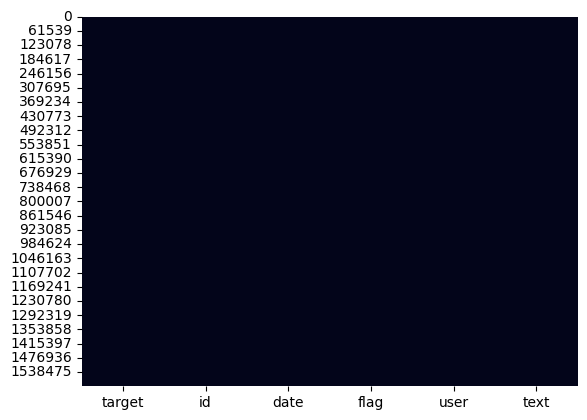

In [ ]:
# Afficher une heatmap des valeurs manquantes.
sns.heatmap(data.isna(), cbar=False)

In [27]:
# Identification des lignes avec des doublons dans la colonne "id"
duplicates = data[data.duplicated(subset=['id'])]
print(len(duplicates))

1685


In [28]:
# Suppression des doublons pour id en conservant la premi√®re occurrence
data_without_duplicated = data.drop_duplicates(subset='id', keep='first')

In [29]:
# Identification des lignes avec des doublons dans la colonne "id"
second_duplicates = data_without_duplicated[data_without_duplicated.duplicated(subset=['date', 'user', 'text'])]
print(len(second_duplicates))

188


In [30]:
# Suppression des doublons pour date, user, texte en conservant la premi√®re occurrence
data = data_without_duplicated.drop_duplicates(subset=['date', 'user', 'text'], keep='first')

In [31]:
print(data.shape)

(1598127, 6)


Le DataFrame contient 1598127 tweets, d√©crits par 6 caract√©ristiques. La cible qui est le sentiment n√©gatif √©gal √† 0 et le sentiment positif √©gal √† 1. Les caract√©ristiques explicatives sont l'identifiant du tweets, le flag, la date, le r√©dacteur et le texte.

L'analyse pr√©liminaire r√©v√®le une qualit√© de donn√©es satisfaisante, avec peu de valeurs manquantes.

##B. Analyse des variables

###1. Cible

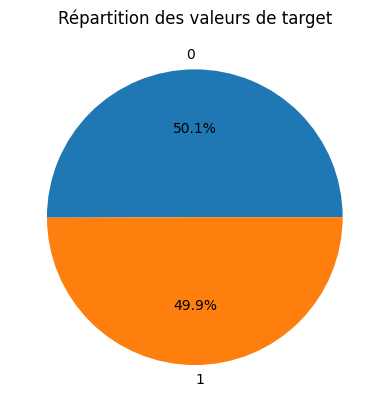

In [ ]:
import matplotlib.pyplot as plt

# Compter les occurrences (corrig√©)
value_counts = data['target'].value_counts()

# Cr√©er un diagramme circulaire avec Matplotlib
plt.pie(value_counts.values, labels=value_counts.index, autopct='%1.1f%%')
plt.title('R√©partition des valeurs de target')
plt.show()

###2. Utilisateur

In [ ]:
# Compter les occurrences de chaque valeur dans la colonne 'target'
value_counts = data['user'].value_counts(normalize=True, sort=True)
print(value_counts)

user
lost_dog           3.435271e-04
webwoke            2.158777e-04
tweetpet           1.933513e-04
SallytheShizzle    1.758308e-04
VioletsCRUK        1.745794e-04
                       ...     
alannamalyn        6.257325e-07
robertreset        6.257325e-07
juicybabyyy        6.257325e-07
david_ashley       6.257325e-07
bpbabe             6.257325e-07
Name: proportion, Length: 659775, dtype: float64


###3. Date

In [ ]:
# Compter les occurrences de chaque valeur dans la colonne 'target'
value_counts = data['date'].value_counts(normalize=True, sort=True)
print(value_counts)

date
Mon Jun 15 12:53:14 PDT 2009    1.251465e-05
Mon Jun 15 13:39:50 PDT 2009    1.063745e-05
Fri May 22 05:10:17 PDT 2009    1.063745e-05
Fri May 29 13:40:04 PDT 2009    1.063745e-05
Fri Jun 05 14:13:07 PDT 2009    1.001172e-05
                                    ...     
Sun Jun 07 12:31:22 PDT 2009    6.257325e-07
Sun Jun 07 12:31:19 PDT 2009    6.257325e-07
Sun Jun 07 12:31:17 PDT 2009    6.257325e-07
Sun Jun 07 12:31:16 PDT 2009    6.257325e-07
Tue Jun 16 08:40:50 PDT 2009    6.257325e-07
Name: proportion, Length: 774363, dtype: float64


###4. Flag

In [ ]:
# Compter les occurrences de chaque valeur dans la colonne 'target'
value_counts = data['flag'].value_counts(normalize=True, sort=True)
print(value_counts)

flag
NO_QUERY    1.0
Name: proportion, dtype: float64


##C. Pr√©-traitement du texte

Les tweets contiennent souvent des mentions d'autres utilisateurs, des liens hypertextes, des √©mojis et de la ponctuation. Pour entra√Æner un mod√®le de langage sur ces donn√©es, il est n√©cessaire de les nettoyer et de les pr√©traiter.

√âtapes de pr√©traitement :

* Minusculisation : Conversion de tout le texte en minuscules pour une meilleure uniformit√©.

* Remplacement des URL : Remplacement des liens par un mot g√©n√©rique comme "URL" pour √©viter qu'ils soient trait√©s comme des mots.

* Remplacement des √©mojis : Association des √©mojis √† des repr√©sentations textuelles (par exemple, ":)" devient "SOURIRE") √† l'aide d'un dictionnaire pr√©d√©fini.

* Remplacement des noms d'utilisateur : Remplacement des noms d'utilisateur par un mot g√©n√©rique comme "UTILISATEUR" pour prot√©ger la vie priv√©e.

* Suppression des caract√®res non alphab√©tiques : Suppression des caract√®res qui ne sont ni des chiffres ni des lettres pour se concentrer sur le contenu textuel.

* R√©duction des lettres cons√©cutives : R√©duction des lettres cons√©cutives √† un maximum de deux pour g√©rer les r√©p√©titions de caract√®res.

* Suppression des mots courts : Suppression des mots de moins de deux caract√®res, car ils ont souvent peu de sens.

* Suppression des stop-words : Elimination des mots courants (stop-words) qui contribuent peu au sens global du texte.

* Lemmatisation : R√©duction des mots √† leur racine (lemme) pour diminuer le nombre de mots uniques et am√©liorer la g√©n√©ralisation.

**Stemming et Lemmatisation**

En raison des r√®gles grammaticales, les documents utilisent diff√©rentes formes d'un m√™me mot, comme "√©crire", "√©crivant" et "√©crit". De plus, il existe des familles de mots d√©riv√©s ayant des significations similaires. Le but du stemming et de la lemmatisation est de r√©duire les formes flexionnelles et parfois les formes d√©riv√©es d'un mot √† une forme de base commune.

* **Stemming** est g√©n√©ralement un processus qui consiste √† couper les fins des mots dans l'espoir d'atteindre le but correctement la plupart du temps. Il inclut souvent la suppression des affixes d√©rivationnels.

* **Lemmatisation** est g√©n√©ralement un processus plus pr√©cis qui utilise un vocabulaire et une analyse morphologique des mots pour supprimer uniquement les terminaisons flexionnelles et retourner la forme de base et la forme du dictionnaire d'un mot.

In [32]:
# Definir le dictionnaire contenant les √©mojis avec leurs significations.
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad',
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed',
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink',
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

# Definir tous les stopwords in english.
stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from',
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're',
             's', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those',
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']
final_stopwords = list(stopwords.words('english'))+stopwordlist

# Cr√©er un Lemmatiseur et un Stemming.
lemmatizer = WordNetLemmatizer()
stemmer = SnowballStemmer(language='english')

# D√©finir des mod√®les d'expressions r√©guli√®res.
urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
userPattern       = '@[^\s]+'
alphaPattern      = "[^a-zA-Z0-9]"
sequencePattern   = r"(.)\1\1+"
seqReplacePattern = r"\1\1"

In [33]:
def preprocess_text(tweet: str,
                    stem_or_lem: str = "lem"
                    ) -> str:
    """
    Cette fonction applique le pr√©traitement √† un tweet :
      1* Si le tweet est une liste, concat√©ne en une seule chaine.
      2* Convertir le tweet en minuscule.
      3* Remplacez toutes les URL par ¬´URL¬ª.
      4* Remplacer tous les emojis par un mot.
      5* Remplacer @USERNAME par 'USER'.
      6* Remplacer tous les caract√®res non alphabets par un espace.
      7* Remplacer 3 lettres cons√©cutives ou plus par 2 lettres.
      8* V√©rifier si le mot est dans stopwordlist.
      9* Lemmatiser ou stemmed le mot si pas dans stopword.
    Args:
      tweet (str): Texte du tweet √† pr√©traiter.
      stem_or_lem (str): Valeurs possibles "lem"/"stem". Permet de choisir si
      le texte doit √™tre stemm√© ou lemmatis√©.
    Returns:
      tweetwords (str): Texte apr√®s le pr√©traitement
    """

    if type(tweet) == list:
        tweet = " ".join(tweet)
    # Convertir le tweet en minuscule.
    tweet = tweet.lower()
    # Remplacez toutes les URL par ¬´URL¬ª.
    tweet = re.sub(urlPattern,"URL",tweet)
    # Remplacer tous les emojis par un mot.
    for emoji in emojis.keys():
        tweet = tweet.replace(emoji, "EMOJI" + emojis[emoji])
    # Remplacer @USERNAME par 'USER'.
    tweet = re.sub(userPattern,' USER', tweet)
    # Remplacer tous les caract√®res non alphabets par un espace.
    tweet = re.sub(alphaPattern, " ", tweet)
    # Remplacer 3 lettres cons√©cutives ou plus par 2 lettres.
    tweet = re.sub(sequencePattern, seqReplacePattern, tweet)

    tweetwords = ''
    for word in tweet.split():
        # V√©rifier si le mot est dans stopwordlist:
        if len(word)>1 and word not in final_stopwords:
            # Lemmatizing ou stemming le mot si pas dans stopword.
            if stem_or_lem == "lem":
                word = lemmatizer.lemmatize(word)
            elif stem_or_lem == "stem":
                word = stemmer.stem(word)
            tweetwords += (word+' ')

    return tweetwords

In [ ]:
data["preprocessed_stem"] = data["text"].apply(lambda x: preprocess_text(x, stem_or_lem="stem"))

In [ ]:
data["preprocessed_lem"] = data["text"].apply(lambda x: preprocess_text(x, stem_or_lem="lem"))

In [ ]:
data.head()

target          id                          date      flag  \
0       0  1467810369  Mon Apr 06 22:19:45 PDT 2009  NO_QUERY   
1       0  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY   
2       0  1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY   
3       0  1467811184  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   
4       0  1467811193  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   

              user                                               text  \
0  _TheSpecialOne_  @switchfoot http://twitpic.com/2y1zl - Awww, t...   
1    scotthamilton  is upset that he can't update his Facebook by ...   
2         mattycus  @Kenichan I dived many times for the ball. Man...   
3          ElleCTF    my whole body feels itchy and like its on fire    
4           Karoli  @nationwideclass no, it's not behaving at all....   

                                   preprocessed_stem  \
0  user url aww bummer shoulda got david carr thi...   
1  upset updat facebook text might cri result sch...   
2  user dive mani time ball manag save 50 rest go...   
3                   whole bodi feel itchi like fire    
4                                user behav mad see    

                                    preprocessed_lem  
0  USER URL aww bummer shoulda got david carr thi...  
1  upset update facebook texting might cry result...  
2  USER dived many time ball managed save 50 rest...  
3                   whole body feel itchy like fire   
4                             USER behaving mad see

#III. Division du dataset

In [34]:
# Diviser le dataset
X_train, X_test, y_train, y_test = train_test_split(data["text"],
                                                    data["target"],
                                                    test_size = 0.15)

#IV. Mod√®le sur mesure simple


##First. MLflow Tracking avec DagsHubs

###Install MLFlow & the DagsHub python client

In [35]:
%pip install -q dagshub mlflow

###Use the DagsHub client to setup connection information for MLflow

In [36]:
import dagshub
dagshub.init(repo_owner='maximemasson65', repo_name='my-first-repo', mlflow=True)

Initialized MLflow to track repo "maximemasson65/my-first-repo"

Repository maximemasson65/my-first-repo initialized!

##A. Vectorisation TF-IDF

In [37]:
# Appliquer le pr√©-traitement avec lemmatisation
X_train_preprocessed = [preprocess_text(text) for text in X_train]
X_test_preprocessed = [preprocess_text(text) for text in X_test]

In [38]:
# TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(min_df=0.005, max_df=0.99)
# Entainer le mod√®le
tfidf_vectorizer.fit(X_train_preprocessed)
# Obtenir les noms caract√©ristiques.
tfidf_features = tfidf_vectorizer.get_feature_names_out()
print("[INFO] : Nombre de caract√©ristiques dans le vocabulaire : ", len(tfidf_features))

[INFO] : Nombre de caract√©ristiques dans le vocabulaire :  235


In [ ]:
print(tfidf_vectorizer.get_feature_names_out())

['actually' 'already' 'also' 'always' 'amazing' 'amp' 'another' 'anything'
 'around' 'away' 'awesome' 'aww' 'baby' 'back' 'bad' 'beautiful' 'bed'
 'best' 'better' 'big' 'birthday' 'bit' 'bored' 'boy' 'call' 'cant' 'car'
 'check' 'cold' 'come' 'coming' 'cool' 'could' 'damn' 'day' 'done' 'dont'
 'early' 'emojiwink' 'end' 'even' 'ever' 'everyone' 'exam' 'excited'
 'feel' 'feeling' 'finally' 'find' 'first' 'follow' 'follower' 'found'
 'friday' 'friend' 'fun' 'game' 'get' 'getting' 'girl' 'give' 'glad' 'go'
 'god' 'going' 'gone' 'gonna' 'good' 'got' 'gotta' 'great' 'guess' 'guy'
 'haha' 'happy' 'hard' 'hate' 'head' 'hear' 'help' 'hey' 'hi' 'home'
 'hope' 'hot' 'hour' 'house' 'hurt' 'im' 'job' 'keep' 'know' 'last' 'late'
 'later' 'least' 'left' 'let' 'life' 'like' 'little' 'live' 'lol' 'long'
 'look' 'looking' 'lost' 'lot' 'love' 'lt' 'luck' 'made' 'make' 'making'
 'man' 'many' 'may' 'maybe' 'mean' 'might' 'miss' 'missed' 'missing' 'mom'
 'monday' 'morning' 'movie' 'much' 'music' 'must' 'nee

In [39]:
# Transformer les donn√©es.
X_train_lr = tfidf_vectorizer.transform(X_train_preprocessed)
X_test_lr  = tfidf_vectorizer.transform(X_test_preprocessed)

In [40]:
from joblib import dump, load
# Enregistrement
dump(tfidf_vectorizer, '/content/drive/My Drive/Projet_7/tfidf_vectorizer.joblib')

['/content/drive/My Drive/Projet_7/tfidf_vectorizer.joblib']

##B. R√©gression Logistique

In [41]:
def evaluate_model(model, use_cv=False):
    """
    Cette fonction √©value un mod√®le
    Args:
      model (sklearn model): mod√®le √† √©valuer.
      use_cv (boolean): contr√¥le la crossvalidation.
    Returns:
      Rien
    """
    # Effectue le test avec ou sans cross-validation
    if use_cv:
        y_pred = cross_val_predict(model, X_test_lr, y_test)
    else:
        y_pred = model.predict(X_test_lr)

    # Effectue le test en donnant la probabilit√©
    if use_cv:
        pred_prob = cross_val_predict(model, X_test_lr, y_test, method='predict_proba')
    else:
        pred_prob = model.predict_proba(X_test_lr)

    # Mise en place du score AUC
    auc_score = roc_auc_score(y_test, pred_prob[:,1])
    print("ROC AUC score : ", round(auc_score, 3))

    # Mise en place de la courbe roc
    fpr, tpr, _ = roc_curve(y_test,  pred_prob[:,1])

    # Afficher la courbe roc
    fig_roc_curve, ax_roc_curve = plt.subplots()
    ax_roc_curve.plot(fpr,tpr,label="AUC="+str(round(auc_score, 3)))
    ax_roc_curve.set_ylabel("True Positive Rate")
    ax_roc_curve.set_xlabel("False Positive Rate")
    ax_roc_curve.legend(loc=4)

    # Afficher le rapport de classification.
    print(classification_report(y_test, y_pred))

    # Afficher la matrice de confusion
    cf_matrix = confusion_matrix(y_test, y_pred)
    cmd = ConfusionMatrixDisplay(cf_matrix, display_labels=["Negative", "Positive"])
    fig_cmd, ax_cmd = plt.subplots()
    cmd.plot(ax=ax_cmd)

    return auc_score, fig_roc_curve, fig_cmd

In [42]:
import mlflow

ROC AUC score :  0.775
              precision    recall  f1-score   support

           0       0.70      0.69      0.70    119940
           1       0.70      0.71      0.70    119780

    accuracy                           0.70    239720
   macro avg       0.70      0.70      0.70    239720
weighted avg       0.70      0.70      0.70    239720



2025/01/24 13:51:31 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


üèÉ View run Mod√®le de r√©gression logistique at: https://dagshub.com/maximemasson65/my-first-repo.mlflow/#/experiments/0/runs/a39fdc3324924bc88d77164acfaa9966
üß™ View experiment at: https://dagshub.com/maximemasson65/my-first-repo.mlflow/#/experiments/0


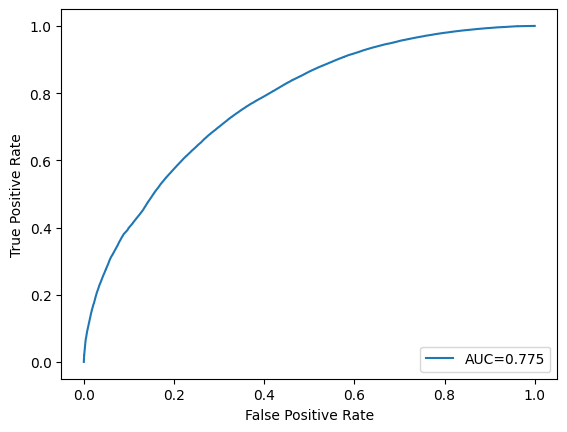

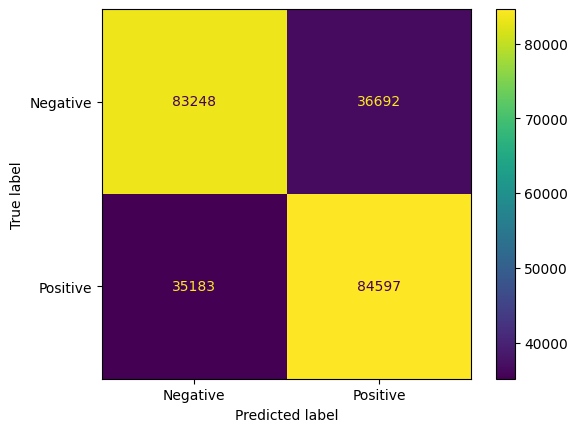

In [ ]:
with mlflow.start_run(run_name="Mod√®le de r√©gression logistique"):
    # Params
    max_iter = 1000
    # Save params
    mlflow.log_param("max_iter", max_iter)
    # Model
    model_log_reg = LogisticRegression(max_iter=max_iter)
    model_log_reg.fit(X_train_lr, y_train)

    auc_score, fig_roc_curve, fig_cmd = evaluate_model(model_log_reg, use_cv=True)
    # Save Metrics
    mlflow.log_metric("auc", auc_score)
    # Save figure
    mlflow.log_figure(fig_roc_curve, "fig_roc_curve.png")
    mlflow.log_figure(fig_cmd, "fig_cmd.png")
    # Enregistrer le mod√®le
    mlflow.sklearn.log_model(model_log_reg, "model_log_reg")

Tunnel http : ngrok donne une adresse publique

##C. XGBoost

In [43]:
import xgboost as xgb

ROC AUC score :  0.745
              precision    recall  f1-score   support

           0       0.67      0.68      0.67    119929
           1       0.67      0.66      0.67    119791

    accuracy                           0.67    239720
   macro avg       0.67      0.67      0.67    239720
weighted avg       0.67      0.67      0.67    239720



2025/01/24 15:13:26 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


üèÉ View run Mod√®le de Xgboost at: https://dagshub.com/maximemasson65/my-first-repo.mlflow/#/experiments/0/runs/4e03909d96e44688a053db8db6340232
üß™ View experiment at: https://dagshub.com/maximemasson65/my-first-repo.mlflow/#/experiments/0


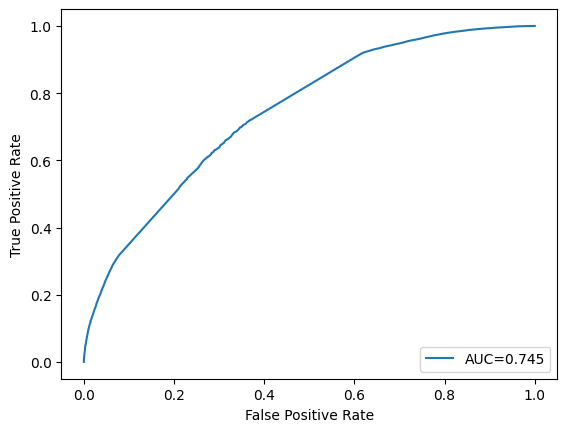

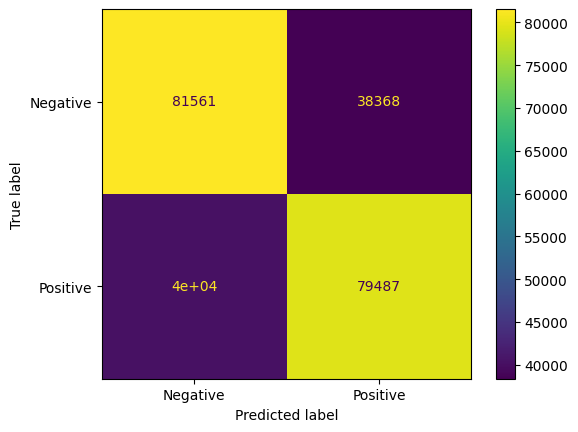

In [45]:
with mlflow.start_run(run_name="Mod√®le de Xgboost"):
    # Params
    objective = 'binary:logistic'
    eval_metric='auc'
    n_estimators=100
    max_depth=3
    learning_rate=0.1
    random_state=42

    # Save params
    mlflow.log_param("objective", objective)
    mlflow.log_param("eval_metric", eval_metric)
    mlflow.log_param("n_estimators", n_estimators)
    mlflow.log_param("max_depth", max_depth)
    mlflow.log_param("learning_rate", learning_rate)
    mlflow.log_param("random_state", random_state)
    # Mise en place du mod√®le de XGBoost
    model_xgb = xgb.XGBClassifier(
        objective=objective,
        eval_metric=eval_metric,
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        use_label_encoder=False
        )
    model_xgb.fit(X_train_lr, y_train)

    auc_score, fig_roc_curve, fig_cmd = evaluate_model(model_xgb, use_cv=False)
    # Save Metrics
    mlflow.log_metric("auc", auc_score)
    # Save figure
    mlflow.log_figure(fig_roc_curve, "fig_roc_curve.png")
    mlflow.log_figure(fig_cmd, "fig_cmd.png")
    # Enregistrer le mod√®le
    mlflow.sklearn.log_model(model_xgb, "model_xgb")

ROC AUC score :  0.782
              precision    recall  f1-score   support

           0       0.71      0.69      0.70    119929
           1       0.70      0.71      0.71    119791

    accuracy                           0.70    239720
   macro avg       0.70      0.70      0.70    239720
weighted avg       0.70      0.70      0.70    239720



2025/01/24 15:24:36 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


üèÉ View run Mod√®le de Xgboost at: https://dagshub.com/maximemasson65/my-first-repo.mlflow/#/experiments/0/runs/b806a8014ca04b4f95bed48eaf039b72
üß™ View experiment at: https://dagshub.com/maximemasson65/my-first-repo.mlflow/#/experiments/0


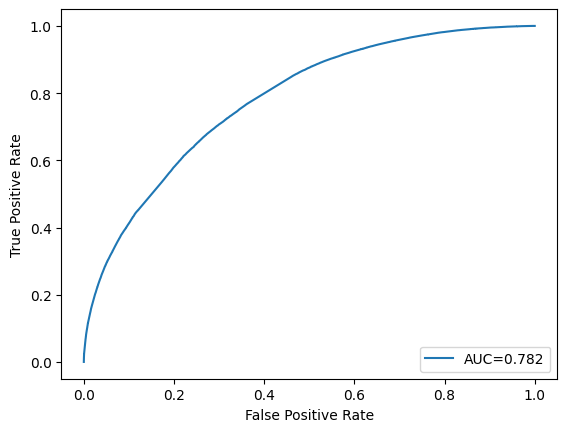

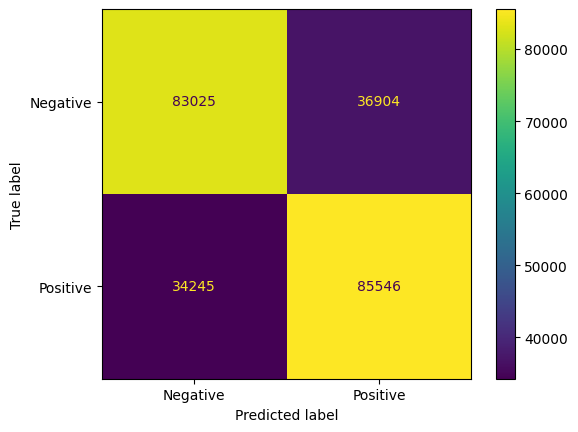

In [46]:
with mlflow.start_run(run_name="Mod√®le de Xgboost"):
    # Params
    objective = 'binary:logistic'
    eval_metric='auc'
    n_estimators=500
    max_depth=3
    learning_rate=0.1
    random_state=42

    # Save params
    mlflow.log_param("objective", objective)
    mlflow.log_param("eval_metric", eval_metric)
    mlflow.log_param("n_estimators", n_estimators)
    mlflow.log_param("max_depth", max_depth)
    mlflow.log_param("learning_rate", learning_rate)
    mlflow.log_param("random_state", random_state)
    # Mise en place du mod√®le de XGBoost
    model_xgb = xgb.XGBClassifier(
        objective=objective,
        eval_metric=eval_metric,
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        use_label_encoder=False
        )
    model_xgb.fit(X_train_lr, y_train)

    auc_score, fig_roc_curve, fig_cmd = evaluate_model(model_xgb, use_cv=False)
    # Save Metrics
    mlflow.log_metric("auc", auc_score)
    # Save figure
    mlflow.log_figure(fig_roc_curve, "fig_roc_curve.png")
    mlflow.log_figure(fig_cmd, "fig_cmd.png")
    # Enregistrer le mod√®le
    mlflow.sklearn.log_model(model_xgb, "model_xgb")

In [ ]:
model_xgb.save_model('/content/drive/My Drive/Projet_7/xgb_model.model')

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:27:34] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)


#V. Mod√®le sur mesure avanc√©: LSTM

##A. Pr√©-traitement

Avant d'ins√©rer des donn√©es textuelles dans un r√©seau neuronal, nous devons repenser le processus de pr√©traitement

###1. Importer les modules

In [ ]:
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

###2. Tokenization

In [ ]:
# Vectoriser le texte.
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

# Obtenir le nombre de mots
word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1
print("Nombre de mots:", vocab_size)

Nombre de mots: 619925


###3. Pad

L'objet tokenizer peut √™tre utilis√© pour convertir n'importe quel mot en une cl√© dans le dictionnaire.

Pour construire un mod√®le de s√©quence, je dois introduire une s√©quence de nombres. Et √©galement s'assurer qu'il n'y a pas de variation dans les formes d'entr√©e des s√©quences. Tout doit √™tre de la m√™me longueur. Mais les textes dans les tweets ont un nombre de mots diff√©rent. Pour √©viter cela, le pad fera toute la s√©quence dans une longueur constante MAX_SEQUENCE_LENGTH.

La longueur des tweets est la plupart du temps √©gale √† 140. La longueur maximal de la s√©quence est d√©finit √† 140.

In [ ]:
MAX_SEQUENCE_LENGTH = 140

In [ ]:
# Pad
X_train_padded = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen = MAX_SEQUENCE_LENGTH)
X_test_padded = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen = MAX_SEQUENCE_LENGTH)

print("Training X Shape:",X_train_padded.shape)
print("Testing X Shape:",X_test_padded.shape)

Training X Shape: (1358407, 140)
Testing X Shape: (239720, 140)


###4. Label encoding

Le mod√®le pour pr√©dire la classe sous forme cod√©e (0 ou 1 car il s'agit d'une classification binaire). Nous devons encoder nos √©tiquettes d'entra√Ænement en encodages

In [ ]:
# label encoder
encoder = LabelEncoder()
encoder.fit(y_train)

y_train_encoded = encoder.transform(y_train)
y_test_encoded = encoder.transform(y_test)

# Reshape
y_train_encoded = y_train_encoded.reshape(-1,1)
y_test_encoded = y_test_encoded.reshape(-1,1)

print("y_train shape:", y_train_encoded.shape)
print("y_test shape:", y_test_encoded.shape)

y_train shape: (1358407, 1)
y_test shape: (239720, 1)


In [ ]:
def preprocess_sequence(X_train, X_test):
    """
    Cette fonction permet le pre traitement

    Args:
      X_train (np.array): Textes d'entrainement √† pr√©-trait√©s
      X_test (np.array): Textes de test √† pr√©-trait√©s
      y_train (np.array): Sentiment d'entrainement √† pr√©-trait√©s
      y_test (np.array): Sentiment de test √† pr√©-trait√©s

    Returns:
      X_train_padded (np.array): Textes d'entrainement pr√©-trait√©s
      X_test_padded  (np.array): Textes de test pr√©-trait√©s
      y_train_encoded (np.array): Sentiment d'entrainement encoder
      y_test_encoded (np.array): Sentiment encoder
      vocab_size (int): Longueur du vocabulaire
      tokenizer (Keras Tokenizer): Entra√Æner sur X_train
    """

    # Tokenizer le texte.
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(X_train)

    word_index = tokenizer.word_index
    vocab_size = len(tokenizer.word_index) + 1
    print("Vocabulary Size :", vocab_size)

    # Pad
    X_train_padded = pad_sequences(tokenizer.texts_to_sequences(X_train),
                        maxlen = MAX_SEQUENCE_LENGTH)
    X_test_padded = pad_sequences(tokenizer.texts_to_sequences(X_test),
                           maxlen = MAX_SEQUENCE_LENGTH)

    # label encoder
    encoder = LabelEncoder()
    encoder.fit(y_train)
    y_train_encoded = encoder.transform(y_train)
    y_test_encoded = encoder.transform(y_test)

    # Reshape
    y_train_encoded = y_train_encoded.reshape(-1,1)
    y_test_encoded = y_test_encoded.reshape(-1,1)

    return X_train_padded, X_test_padded, y_train_encoded, y_test_encoded, vocab_size, tokenizer

In [ ]:
X_train_padded, X_test_padded, y_train_encoded, y_test_encoded, vocab_size, tokenizer = preprocess_sequence(X_train, X_test)

Vocabulary Size : 619925


##B. Mod√®le

Dans le mod√®le de langage, les mots sont repr√©sent√©s de mani√®re √† donner plus de sens et √† apprendre les mod√®les et le sens contextuel qui se cachent derri√®re.

L'incorporation de mots est l'une des repr√©sentations les plus populaires du vocabulaire des documents. Elle est capable de capturer le contexte d'un mot dans un document, la similarit√© s√©mantique et syntaxique, la relation avec d'autres mots, etc.

Il s'agit essentiellement d'une repr√©sentation vectorielle de caract√©ristiques de mots qui sont utilis√©s pour d'autres applications de traitement du langage naturel.

J'utilise ici l'apprentissage par transfert. Je t√©l√©charge l'incorporation pr√©-entra√Æn√©e et l'utilisons du mod√®le.

L'incorporation de mots pr√©-entra√Æn√©e comme GloVe, Word2Vec ou Fasttext donne plus d'informations sur un mot qui peut √™tre utilis√© pour la classification

###1. T√©l√©chargement de Glove embedding

In [ ]:
# T√©l√©charger les fichiers Glove embedding.
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2024-12-10 08:21:16--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2024-12-10 08:21:17--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2024-12-10 08:21:17--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‚Äòglove.6B.zip‚Äô



###2. T√©l√©chargement de Fasttext embedding

In [ ]:
# T√©l√©charger les fichier Fasttext embedding.
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz
!gunzip cc.en.300.vec.gz

--2024-12-10 08:25:00--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 18.154.144.74, 18.154.144.87, 18.154.144.13, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|18.154.144.74|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1325960915 (1.2G) [binary/octet-stream]
Saving to: ‚Äòcc.en.300.vec.gz‚Äô

cc.en.300.vec.gz    100%[===================>]   1.23G  51.3MB/s    in 28s     

2024-12-10 08:25:28 (45.5 MB/s) - ‚Äòcc.en.300.vec.gz‚Äô saved [1325960915/1325960915]



###3. Cr√©er une matrice d'embedding

Pour entra√Æner nos mod√®les d'apprentissage profond, nous avons besoin d'une couche d'int√©gration qui aura certains poids. Ces poids seront le coefficient dans une matrice d'int√©gration

In [ ]:
# Pour les mod√®les Glove et Fasttext, des vecteurs de longueur 300 on √©t√© choisit
EMBEDDING_DIM = 300
EMBEDDING_DICT = {"glove":"glove.6B.300d.txt", "fasttext":"cc.en.300.vec"}

In [ ]:
def get_embedding_matrix(embedding_file, vocab_size):

    """
    Cette fonction met en place la fonction d'embedding
    Args:
      embedding_file (str): chemin vers le fichier du mod√®le d'int√©gration
      vocab_size (int): Longueur du vocabulaire
    Returns:
      embedding_matrix (np.array): matrice d'int√©gration qui sera utilis√©e
      pour la couche d'int√©gration
    """
    # Cr√©ation d'un dictionnaire d'index d'int√©gration utilis√© pour
    # mapper les mots avec leur vecteur
    embeddings_index = {}

    print("[INFO] : Calcul de la matrice d'int√©gration pour : ", embedding_file)

    # Transformer le fichier d'int√©gration en dictionnaire
    with open(embedding_file) as f:
        for line in f:
          values = line.split()
          word = value = values[0]
          coefs = np.asarray(values[1:], dtype='float32')
          embeddings_index[word] = coefs

        print('Found %s word vectors.' %len(embeddings_index))

    # Cr√©er la matrice d'int√©gration de taille [vocab_size, EMBEDDING_DIM]
    embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
    for word, i in word_index.items():
      embedding_vector = embeddings_index.get(word)
      if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

    return embedding_matrix

In [ ]:
embedding_matrix = get_embedding_matrix(embedding_file="glove.6B.300d.txt", vocab_size=vocab_size)

[INFO] : Calcul de la matrice d'int√©gration pour :  glove.6B.300d.txt
Found 400000 word vectors.


###4. Cr√©er le mod√®le Deep learning

####a. Cr√©er une couche d'embedding

La couche d'int√©gration sera la premi√®re couche des r√©seaux de neurones. Il convertira les s√©quences de texte en vecteurs d'int√©gration

In [ ]:
# Cr√©er de la couche d'int√©gration
embedding_layer = tf.keras.layers.Embedding(vocab_size,
                                          EMBEDDING_DIM,
                                          weights=[embedding_matrix],
                                          input_length=MAX_SEQUENCE_LENGTH,
                                          trainable=False)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


#### b. Cr√©er le mod√®le

LSTM - Long Short Term Memory, c'est une variante de RNN qui a une cellule d'√©tat de m√©moire pour apprendre le contexte des mots qui se trouvent plus loin dans le texte afin de porter une signification contextuelle plut√¥t que de simples mots voisins comme dans le cas de RNN.

In [ ]:
from keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout, Flatten, SpatialDropout1D
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.optimizers import Adam, SGD
from keras.callbacks import ReduceLROnPlateau

In [ ]:
def get_bidirLSTM_model(dropout_rate, optimizer, loss_function):

    """
    Cette fonction cr√©e et compile un mod√®le LSTM bidirectionnel.

    Args:
      dropout_rate (float): Une partie des neurones √† d√©sactiver sur chaque couche
      optimizer (Keras optimizer): Optimiseur √† utiliser pour la descente de gradient
      loss_function (str): Fonction de perte √† utiliser pour calculer l'erreur empirique

    Returns:
      model (Keras model): mod√®le compil√© cr√©√© selon une architecture sp√©cifique

    """

    sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
    embedding_sequences = embedding_layer(sequence_input)
    x = SpatialDropout1D(0.2)(embedding_sequences)
    x = Bidirectional(LSTM(24))(x)
    x = Dropout(dropout_rate)(x)
    x = Dense(16, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(1, activation="sigmoid")(x)
    model = tf.keras.Model(sequence_input, outputs)

    model.compile(optimizer=optimizer, loss=loss_function, metrics=['accuracy'])

    return model

####c. Entra√Ænement

In [ ]:
def plot_train_results(training_history):
    '''
    Fonction pour afficher les courbes d'apprentissage du mod√®le sur les donn√©es d'entra√Ænement
    Args:
      training_history (History object): Historique d'entrainement.
    Returns:
      Rien
    '''
    fig_accuracy_curve, ax_accuracy_curve = plt.subplots()
    ax_accuracy_curve.plot(training_history.history['accuracy'])
    ax_accuracy_curve.plot(training_history.history['val_accuracy'])
    ax_accuracy_curve.set_title('model accuracy')
    ax_accuracy_curve.set_ylabel('accuracy')
    ax_accuracy_curve.set_xlabel('epoch')
    ax_accuracy_curve.legend(['train', 'test'], loc='upper left')

    fig_loss_curve, ax_loss_curve = plt.subplots()
    ax_loss_curve.plot(training_history.history['loss'])
    ax_loss_curve.plot(training_history.history['val_loss'])
    ax_loss_curve.set_title('model loss')
    ax_loss_curve.set_ylabel('loss')
    ax_loss_curve.set_xlabel('epoch')
    ax_loss_curve.legend(['train', 'test'], loc='upper left')

    return fig_accuracy_curve, fig_loss_curve

In [ ]:
def decode_sentiment_label(score):
    """
    Cette fonction:
      * Compare un score d'entr√©e avec un seuil.
      * Fournit une classe d'√©tiquette.
    Args:
      score (float): score d'entr√©e.
    Returns:
      label (str): Valeurs "Positive"/"Negative" correspondant au score.
    """
    return "Positive" if score>0.5 else "Negative"

def decode_sentiment_class(score):
    """
    Cette fonction :
      * Compare un score d'entr√©e avec un seuil.
      * Fournit un identifiant de classe.
    Args:
      score (float): score d'entr√©e
    Returns:
      ID (int): Valeurs binaires correspondant √† la class
    """
    return 1 if score>0.5 else 0

In [ ]:
def evaluate_keras_model(model, xtest, ytest):
    """
    Cette fonction √©value un mod√®le entra√Æn√©.
    Args:
      model (Keras model): un mod√®le Keras entra√Æn√©.
    Returns:
      auc_score (float): AUC score du mod√®le sur l'ensemble de test.
      f1 (float): F1 score du mod√®le sur l'ensemble de test.
      acc (float): accuracy score du mod√®le sur l'ensemble de test.

    """
    # Pr√©dire les probabilit√©s.
    pred_prob = model.predict(xtest)
    # Pr√©dire les valeurs pour l'ensemble de donn√©es de test.
    y_pred = [decode_sentiment_class(score) for score in pred_prob]

    # auc score
    auc_score = roc_auc_score(ytest, pred_prob)
    print("ROC AUC score : ", round(auc_score, 3))
    # f1_score
    f1 = round(f1_score(ytest, y_pred), 3)
    print("F1 Score : ", f1)
    # f1_score
    acc = round(accuracy_score(ytest, y_pred), 3)
    print("Accuracy Score : ", acc)

    # Cr√©er ROC curve
    fpr, tpr, _ = roc_curve(ytest,  pred_prob)

    # Afficher la courbe roc
    fig_roc_curve, ax_roc_curve = plt.subplots()
    ax_roc_curve.plot(fpr,tpr,label="AUC="+str(round(auc_score, 3)))
    ax_roc_curve.set_ylabel("True Positive Rate")
    ax_roc_curve.set_xlabel("False Positive Rate")
    ax_roc_curve.legend(loc=4)

    # Afficher le rapport de classification.
    print(classification_report(y_test, y_pred))

    # Afficher la matrice de confusion
    cf_matrix = confusion_matrix(y_test, y_pred)
    cmd = ConfusionMatrixDisplay(cf_matrix, display_labels=["Negative", "Positive"])
    fig_cmd, ax_cmd = plt.subplots()
    cmd.plot(ax=ax_cmd)

    return auc_score, f1, acc, fig_roc_curve, fig_cmd

Model: "functional"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)                         ‚îÉ Output Shape                ‚îÉ         Param # ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ input_layer (InputLayer)             ‚îÇ (None, 140)                 ‚îÇ               0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ embedding (Embedding)                ‚îÇ (None, 140, 300)            ‚îÇ     185,977,500 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ spatial_dropout1d (SpatialDropout1D) ‚îÇ (None, 140, 300)            ‚îÇ               0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ bidirectional (Bidirectional)        ‚îÇ (None, 48)                  ‚îÇ          62,400 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout (Dropout)                    ‚îÇ (None, 48)                  ‚îÇ               0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense (Dense)                        ‚îÇ (None, 16)                  ‚îÇ             784 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout_1 (Dropout)                  ‚îÇ (None, 16)                  ‚îÇ               0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_1 (Dense)                      ‚îÇ (None, 1)                   ‚îÇ              17 ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

 Total params: 186,040,701 (709.69 MB)

 Trainable params: 63,201 (246.88 KB)

 Non-trainable params: 185,977,500 (709.45 MB)

Epoch 1/20
10613/10613 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 223s 20ms/step - accuracy: 0.7456 - loss: 0.5162 - val_accuracy: 0.7966 - val_loss: 0.4383 - learning_rate: 0.0010
Epoch 2/20
10613/10613 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 218s 21ms/step - accuracy: 0.7871 - loss: 0.4577 - val_accuracy: 0.8021 - val_loss: 0.4263 - learning_rate: 0.0010
Epoch 3/20
10613/10613 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 267s 21ms/step - accuracy: 0.7928 - loss: 0.4485 - val_accuracy: 0.8055 - val_loss: 0.4228 - learning_rate: 0.0010
Epoch 4/20
10613/10613 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 281s 23ms/step - accuracy: 0.7952 - loss: 0.4443 - val_accuracy: 0.8033 - val_loss: 0.4233 - learning_rate: 0.0010
Epoch 5/20
10613/10613 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 260s 23ms/step - accuracy: 0.7982 - loss: 0.4406 - val_accuracy: 0.8077 - val_loss: 0.4177 - learning_rate: 0.0010
Epoch

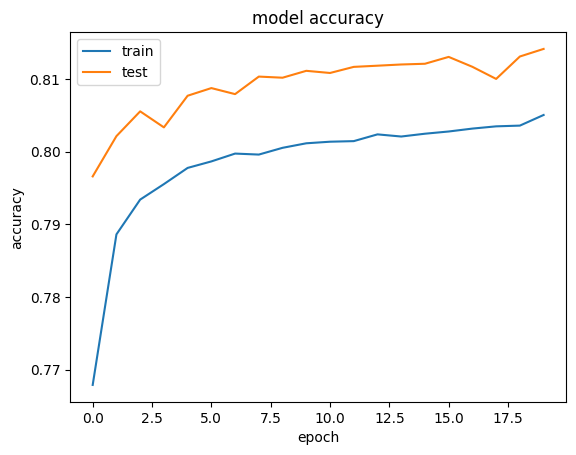

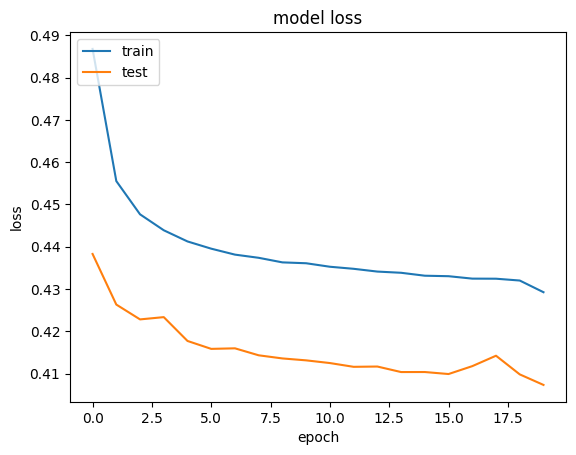

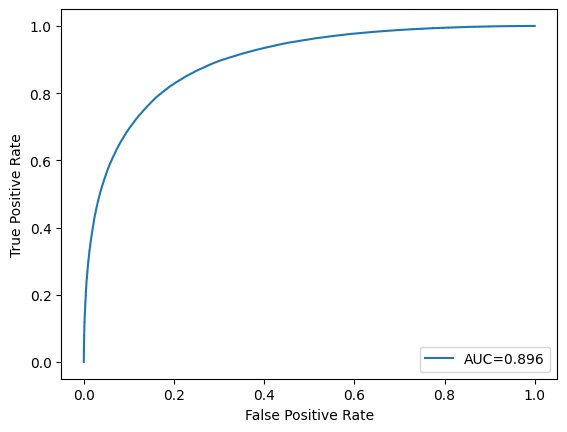

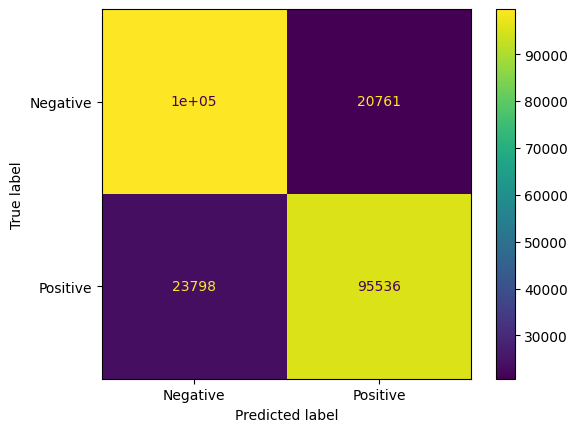

In [ ]:
with mlflow.start_run(run_name="Mod√®le de bidirLSTM"):
    # Params
    dropout_rate=0.25
    optimizer='adam'
    loss_function='binary_crossentropy'

    BATCH_SIZE=128
    EPOCHS= 20

    # Save params
    mlflow.log_param("dropout_rate", dropout_rate)
    mlflow.log_param("optimizer", optimizer)
    mlflow.log_param("loss_function", loss_function)

    mlflow.log_param("batch_size", BATCH_SIZE)
    mlflow.log_param("epochs", EPOCHS)

    # Mise en place du mod√®le de XGBoost
    with tf.device('/gpu:0'):
      # Appeler get_bidirLSTM_model pour obtenir un LSTM bi-directionel.
      model = get_bidirLSTM_model(dropout_rate=dropout_rate,
                                  optimizer=optimizer,
                                  loss_function=loss_function)
      # Check the model architecture
      model.summary()
      # Instancier un rappel de r√©ducteur LR
      ReduceLRCallback = ReduceLROnPlateau(factor=0.5,
                                           min_lr = 1e-10,
                                           monitor = 'val_loss',
                                           patience = 3,
                                           verbose = 1)
      history = model.fit(X_train_padded, y_train_encoded,
                          batch_size=BATCH_SIZE, epochs=EPOCHS,
                          validation_data=(X_test_padded, y_test_encoded),
                          callbacks=[ReduceLRCallback])
      # Enregistrer les m√©triques
      fig_accuracy_curve, fig_loss_curve = plot_train_results(history)

      auc_score, f1, acc, fig_roc_curve, fig_cmd = evaluate_keras_model(model,
                                                                        xtest=X_test_padded,
                                                                        ytest=y_test_encoded)
      # Save Metrics
      mlflow.log_metric("auc", auc_score)
      mlflow.log_metric("f1", f1)
      mlflow.log_metric("acc", acc)

      # Save figure
      mlflow.log_figure(fig_accuracy_curve, "fig_accuracy_curve.png")
      mlflow.log_figure(fig_loss_curve, "fig_loss_curve.png")
      mlflow.log_figure(fig_roc_curve, "fig_roc_curve.png")
      mlflow.log_figure(fig_cmd, "fig_cmd.png")

In [ ]:
model.save("/content/drive/My Drive/Projet_7/bidirLSTM_model.keras")

In [ ]:
import pickle
with open('/content/drive/My Drive/Projet_7/tokenizer.pickle', 'wb') as f:
    pickle.dump(tokenizer, f)

# VI. Comparaison Mod√®les avanc√©s: BERT

Le mod√®le BERT signifiant Bidirectionnel Encoders Representations from Transformers fait l'objet d'un second notebook.